# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загрузка датасета
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
# подсчёт явных дубликатов
labels.duplicated().sum()

0

In [8]:
# рабочий датасет с количеством фотографий по возрастам
work_data_1 = labels.pivot_table(index='real_age', values='file_name', aggfunc='count').reset_index()
work_data_1.head()

,real_age,file_name
0,1,149
1,2,88
2,3,25
3,4,101
4,5,87


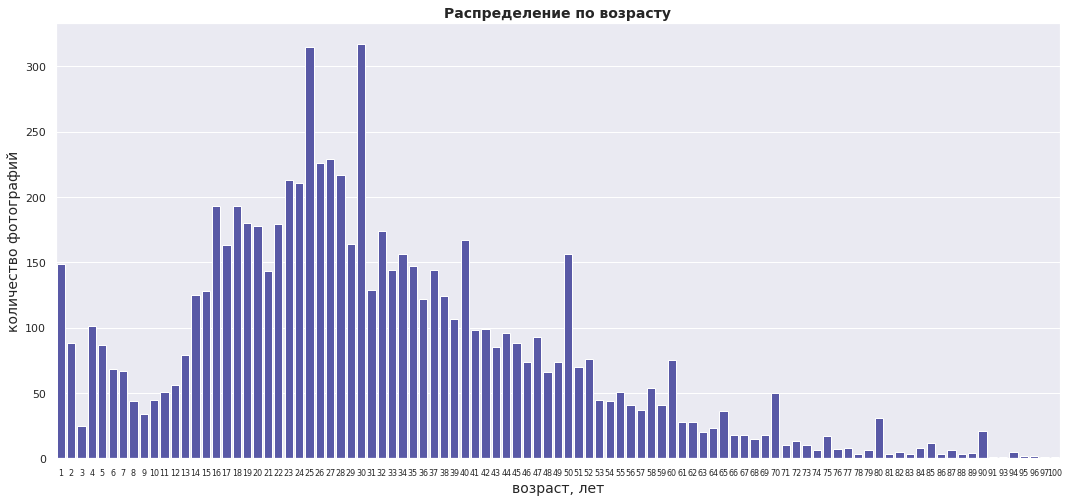

In [9]:
plt.figure(figsize=(18,8));
sns.set(style='darkgrid')
sns.barplot(data=work_data_1, x='real_age', y='file_name', color="blue", saturation=.3)
plt.title("Распределение по возрасту", fontsize=14, weight='bold');
plt.xticks(fontsize=8, rotation=0);
plt.xlabel('возраст, лет', fontsize=14);
plt.ylabel('количество фотографий', fontsize=14);

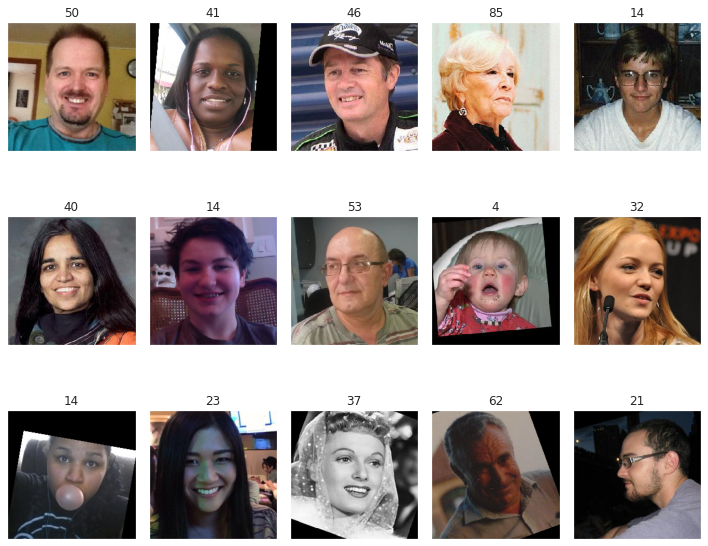

In [10]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете **labels** содержится 7591 запись и 2 поля:
- `file_name` - наименование файла с фото,
- `real_age` - возраст человека, изображенного на фото.

Пропуски и дубликаты в датасете отсутствуют.

Возраст людей на фотографиях варьируется от 1 года до 100 лет. Больше всего фотографий людей от 20 до 30 лет. На графике распределения по возрасту просматривается два явных пика на отметках 25 лет и 30 лет.

В датасете есть как цветные фотографии, так и черно-белые. 

В возрастной группе 60+ фотографий меньше, чем в других возрастных группах.

Для увеличения объёма данных можно применить следующие аугментации: отражение по горизонтали, изменение яркости.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255.,
                                       horizontal_flip=True, brightness_range=(1.2, 1.8))
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=123)
    return train_datagen_flow


def load_test(path):
    labels_test = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255.)

    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe = labels_test,
                                                         directory = path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=123)

    return test_datagen_flow

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

def create_model(input_shape):

    backbone = ResNet50(input_shape = input_shape,
                        weights = 'imagenet',
                        include_top = False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

```

```
Train for 380 steps, validate for 95 steps
Epoch 1/5
2022-07-05 19:40:10.185110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-05 19:40:10.468434: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 57s - loss: 209.6863 - mae: 10.5624 - val_loss: 569.0460 - val_mae: 18.4780
Epoch 2/5
380/380 - 48s - loss: 94.0638 - mae: 7.3977 - val_loss: 127.1080 - val_mae: 8.5026
Epoch 3/5
380/380 - 49s - loss: 65.3238 - mae: 6.1951 - val_loss: 84.7943 - val_mae: 6.9280
Epoch 4/5
380/380 - 48s - loss: 48.8523 - mae: 5.3144 - val_loss: 107.2977 - val_mae: 7.8359
Epoch 5/5
380/380 - 48s - loss: 40.7327 - mae: 4.8802 - val_loss: 72.9675 - val_mae: 6.3995
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 8s - loss: 72.9675 - mae: 6.3995
Test MAE: 6.3995

```

## Анализ обученной модели

- **Загрузка данных:** 

Для загрузки фото была применена динамическая загрузка данных **ImageDataGenerator**. 

Размер изображений приведен к единому размеру **target_size=(224, 224)**.

Количество изображений в батче **batch_size=16** — это золотая середина, т.к. память GPU ограничена. 

Целевые значения записаны в отдельной колонке `real_age`, поэтому установлено значение **class_mode="raw"**. 

В некоторых возрастных категориях было мало фотографий, поэтому была применена **аугментация** - увеличение объёма данных через трансформацию существующего датасета: отражение по горизонтали **horizontal_flip=True**, увеличение яркости **brightness_range=(1.2, 1.8)**. В Keras 1.0 — это нейтральная яркость. Если установить значение выше единицы, изображение станет более светлым.

- **Модель:**

В качестве модели использована нейронная сеть с одним нейроном. Модели задан класс **Sequential**. Этот класс применяется для моделей, в которых слои идут последовательно.

Применена архитектура **ResNet** - глубокая сеть, которая применяет *skip-connections*, свёртки небольшого размера и *bottleneck-блоки*, - а именно модификация этой архитектуры **ResNet50** - сеть с 50 слоями.

Использована функция активации **ReLU**, она приводит к нулю всё, что меньше 0, и пропускает положительные значения без изменений.

Применен алгоритм **Adam**, который подбирает различные параметры для разных нейронов, что ускоряет обучение модели. Для улучшения итогового качества модели скорость обучения была снижена до **lr=0.0001**.

Применен глобальный двумерный пулинг усреднением **GlobalAveragePooling2D** — пулинг с окном во весь тензор, который возвращает среднее значение из группы пикселей внутри канала. GlobalAveragePooling2D нужен, чтобы усреднить информацию по всему изображению, то есть получить пиксель с большим количеством каналов (например, 512 для ResNet50).

- **Результаты:**

Модель обучилась за **5 эпох**.

MAE на тестовой выборке составила **6.3995**.